# Optimizer
vanilla gradient descent? 某种梯度下降的方式？
convergence 收敛  

pytorch 本身有 optim 子模块，包含了各种不同的优化方法，本节就来认识一下

In [1]:
import torch
import numpy as np

In [2]:
# temperature data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]    # Clesius
t_u = [35.7,55.9, 58.2, 81.9, 56.3, 48.9,33.9,21.8,48.4, 60.4, 68.4]    # unknown units
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

每种优化器的结构都需要很多 参数params作为第一输入  
有两个关键思想：  
- zero_grad
- step 
前者将构造时传递给优化器的所有参数的grad属性归零？？  
后者用于更新参数值

In [4]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

### SGD - Stochastic 随机梯度下降  
这里的随机也不是真正的完全随机，而是说：通过对所有输入样本的随机子集（minibatch）求平均值来获得梯度

In [5]:
# linear model
def model(t_u, w, b):
    return w * t_u +ｂ

# loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [6]:
t_p = model(t_u, *params)
loss = loss_fn(t_p,t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

**应当注意到：参数值在调用step属性时被更新了！**  
这里需要对比，才能看的清楚：  
在上一个代码中使用了`params = (params - learning_rate * params.grad).detach().requires_grad_()`从而对params进行了更新

**然后要注意的是还没有把每次优化的gradients置0**  
其实这个东西也没有那么复杂，就是计算完一个batch之后，自然要把gradient归0，否则下一个batch进来的时候，就和上一次的数据混合起来了

In [7]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_un = 0.1 * t_u
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [8]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs+1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


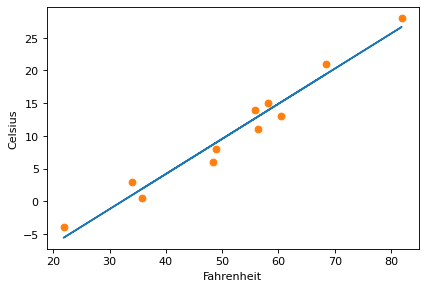

In [9]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs  = 5000,
              optimizer = optimizer,
              params    = params,
              t_u       = t_un,
              t_c       = t_c)
from matplotlib import pyplot as plt

t_p = model(t_un, *params)
fig = plt.figure(dpi = 80)
plt.xlabel("Fahrenheit")
plt.ylabel('Celsius')

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

### 换一种优化器
使用Adam替代SGD也非常的简单，可以直接进行替换  
使用Adam（更为复杂的一种优化器）的好处是：
- 这种优化器自适应地设置了学习率；
- 对参数缩放scale不那么敏感，所以可以直接使用t_u，而不是t_un进行训练
- 即使把学习率增大到 1e-1，也不会崩溃

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


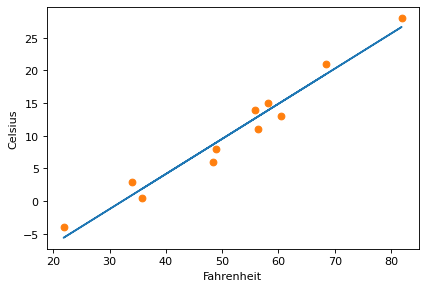

In [10]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs = 2000,
             optimizer = optimizer,
             params = params,
             t_u = t_u,
             t_c = t_c)
from matplotlib import pyplot as plt

t_p = model(t_u, *params)
fig = plt.figure(dpi = 80)
plt.xlabel("Fahrenheit")
plt.ylabel('Celsius')

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

### 一些方法
split and shuffling the data  
分割和清洗数据？？

In [11]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([2, 7, 4, 3, 8, 1, 9, 0, 5]), tensor([ 6, 10]))

上面的代码中使用了randperm函数，看上去也就是打乱顺序的一种函数，不如看一下里面是什么情况  
不过这个函数确实是比较有趣的：
- 注意输入：应该是一个int值
- 再看输出，输出是一个包含0-int的所有数值的列表（当然顺序已经打乱了），也就是index的列表

In [12]:
shuffled_indices

tensor([ 2,  7,  4,  3,  8,  1,  9,  0,  5,  6, 10])

In [13]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

training_loop其实并没有变化，但是希望能够计算一下每个epoch之后对于测试集的loss  
所以也就是增加了一个计算测试集loss的操作

In [25]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    trainLoss_list = []
    valLoss_list = []
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()    # 确保只有train的部分进行了反向传播学习
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(train_loss), float(val_loss)))
        
        trainLoss_list.append(train_loss)
        valLoss_list.append(val_loss)
            
    return params, trainLoss_list, valLoss_list

In [26]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

n_epochs = 3000

params, trainLoss_list, valLoss_list = training_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 75.92778778076172, Validation loss 100.32884979248047
Epoch 2, Training loss 37.46901321411133, Validation loss 45.17414093017578
Epoch 3, Training loss 31.473798751831055, Validation loss 32.525596618652344
Epoch 500, Training loss 8.082870483398438, Validation loss 6.644524097442627
Epoch 1000, Training loss 3.6888363361358643, Validation loss 4.235669136047363
Epoch 1500, Training loss 2.834181785583496, Validation loss 4.4852142333984375
Epoch 2000, Training loss 2.6679515838623047, Validation loss 4.850439071655273
Epoch 2500, Training loss 2.635617971420288, Validation loss 5.061131954193115
Epoch 3000, Training loss 2.6293299198150635, Validation loss 5.163715362548828


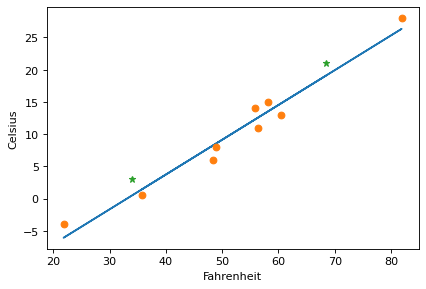

In [22]:
from matplotlib import pyplot as plt

t_p = model(t_un, *params)
fig = plt.figure(dpi = 80)
plt.xlabel("Fahrenheit")
plt.ylabel('Celsius')

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(train_t_u.numpy(), train_t_c.numpy(), 'o')
plt.plot(val_t_u.numpy(), val_t_c.numpy(), '*')

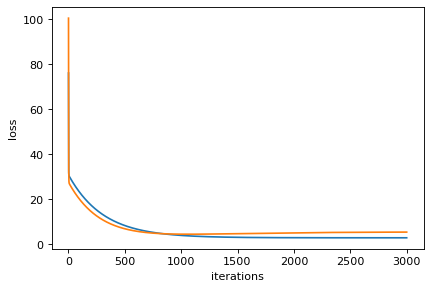

In [29]:
fig = plt.figure(dpi=80)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(1, n_epochs+1), trainLoss_list)
plt.plot(range(1, n_epochs+1), valLoss_list)

文中提到了一个问题，在上面的步骤中，先后计算了train_set和val_set的模型，然后才进行backward，这样不会出错吗？  
没错，则也是我刚才觉得有点疑惑的地方。  
### 计算分离
文中解释：  
当我们使用train_t_u和train_t_p时，产生了一个计算图；  
当我们使用val_t_u和val_t_p时，会产生另一个计算图；  
这两个计算只是使用了同样的函数、同样的模型，但是计算是分离的，当反向传播只再train_set上进行时，就达到了计算分离的目的！  
而两个计算所使用的相同的部分只有**参数**  
当使用backward时，也是针对参数进行的计算

### 开启和关闭 autograd
合理使用`torch.no_grad`，可以减少计算和存储的空间浪费

In [31]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

还有一种方法是使用`torch.set_grad_enabled`方法，从而达到开关autograd的目的

In [32]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss